# Drift Coalescence Test

**The question:** Can tokens that start distinct near the origin coalesce into black holes as they drift outward into coarser lattice regions?

**The mechanism we're testing:**
1. Initialize at N(0, σ) — everyone near origin where bfloat16 lattice is fine
2. Each step: cull 1% of tokens, then translate everyone by a fixed step toward r=0.37
3. After 100 steps: centroid at r≈0.37, ~2,200 survivors remain
4. Count black holes

**Two conditions:**
- σ = 0.02 (realistic Xavier-ish init — control)
- σ = 1e-6 (tight init — test case)

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Constants
N_TOKENS = 151936
N_DIMS = 2560
TARGET_RADIUS = 0.37
N_STEPS = 100

# Derived
STEP_SIZE = TARGET_RADIUS / N_STEPS  # Constant step to reach 0.37 in 100 steps
CULL_PER_STEP = N_TOKENS // N_STEPS  # ~1% per step = 1,519 tokens
N_SURVIVORS = N_TOKENS - (CULL_PER_STEP * N_STEPS)  # Whatever's left

print(f"Tokens: {N_TOKENS:,}")
print(f"Steps: {N_STEPS}")
print(f"Step size: {STEP_SIZE:.4f}")
print(f"Cull per step: {CULL_PER_STEP:,}")
print(f"Survivors after 100 steps: {N_SURVIVORS:,}")

Using device: mps
Tokens: 151,936
Steps: 100
Step size: 0.0037
Cull per step: 1,519
Survivors after 100 steps: 36


In [14]:
# Drift direction (random unit vector, same for both runs)
torch.manual_seed(42)
DRIFT_DIR = torch.randn(N_DIMS, device=device)
DRIFT_DIR = DRIFT_DIR / DRIFT_DIR.norm()
print(f"Drift direction norm: {DRIFT_DIR.norm().item():.6f}")

Drift direction norm: 1.000000


## Condition 1: σ = 0.02 (Realistic Control)

In [15]:
SIGMA_1 = 0.02
print(f"Running with σ = {SIGMA_1}")

# Initialize
torch.manual_seed(42)
W1 = torch.randn(N_TOKENS, N_DIMS, device=device) * SIGMA_1
W1_bf16 = W1.to(torch.bfloat16)

# Initial census
unique_init, counts_init = torch.unique(
    W1_bf16.cpu().view(torch.uint16).to(torch.int32), dim=0,
    return_counts=True
)
print(f"Initial: {len(unique_init):,} unique vectors, {(counts_init > 1).sum().item()} black holes")
print(f"Initial centroid norm: {W1_bf16.float().mean(dim=0).norm().item():.6f}")

Running with σ = 0.02
Initial: 151,936 unique vectors, 0 black holes
Initial centroid norm: 0.002622


In [16]:
# Run simulation
alive_mask_1 = torch.ones(N_TOKENS, dtype=torch.bool, device=device)
history_1 = {'step': [], 'centroid_norm': [], 'n_unique': [], 'n_bh': [], 'max_pop': []}

W1_current = W1_bf16.clone()

for step in tqdm(range(N_STEPS), desc=f"σ={SIGMA_1}"):
    # 1. Cull
    alive_idx = torch.where(alive_mask_1)[0]
    if len(alive_idx) > CULL_PER_STEP:
        cull_idx = alive_idx[torch.randperm(len(alive_idx), device=device)[:CULL_PER_STEP]]
        alive_mask_1[cull_idx] = False
    
    # 2. Drift in float32, then quantize
    W1_fp32 = W1_current.float()
    W1_fp32 = W1_fp32 + STEP_SIZE * DRIFT_DIR
    W1_current = W1_fp32.to(torch.bfloat16)
    
    # 3. Stats
    survivors = W1_current[alive_mask_1]
    centroid_norm = survivors.float().mean(dim=0).norm().item()
    
    unique, counts = torch.unique(
        survivors.cpu().view(torch.uint16).to(torch.int32), dim=0,
        return_counts=True
    )
    
    history_1['step'].append(step)
    history_1['centroid_norm'].append(centroid_norm)
    history_1['n_unique'].append(len(unique))
    history_1['n_bh'].append((counts > 1).sum().item())
    history_1['max_pop'].append(counts.max().item())

print(f"Final: r={history_1['centroid_norm'][-1]:.4f}, survivors={alive_mask_1.sum().item()}, unique={history_1['n_unique'][-1]}, BHs={history_1['n_bh'][-1]}")

σ=0.02:   0%|          | 0/100 [00:00<?, ?it/s]

Final: r=0.3833, survivors=36, unique=36, BHs=0


## Condition 2: σ = 1e-6 (Tight Test)

In [17]:
SIGMA_2 = 1e-6
print(f"Running with σ = {SIGMA_2}")

# Initialize
torch.manual_seed(42)
W2 = torch.randn(N_TOKENS, N_DIMS, device=device) * SIGMA_2
W2_bf16 = W2.to(torch.bfloat16)

# Initial census
unique_init, counts_init = torch.unique(
    W2_bf16.cpu().view(torch.uint16).to(torch.int32), dim=0,
    return_counts=True
)
print(f"Initial: {len(unique_init):,} unique vectors, {(counts_init > 1).sum().item()} black holes")
print(f"Initial centroid norm: {W2_bf16.float().mean(dim=0).norm().item():.6f}")

Running with σ = 1e-06
Initial: 151,936 unique vectors, 0 black holes
Initial centroid norm: 0.000000


In [18]:
# Run simulation
alive_mask_2 = torch.ones(N_TOKENS, dtype=torch.bool, device=device)
history_2 = {'step': [], 'centroid_norm': [], 'n_unique': [], 'n_bh': [], 'max_pop': []}

W2_current = W2_bf16.clone()

for step in tqdm(range(N_STEPS), desc=f"σ={SIGMA_2}"):
    # 1. Cull
    alive_idx = torch.where(alive_mask_2)[0]
    if len(alive_idx) > CULL_PER_STEP:
        cull_idx = alive_idx[torch.randperm(len(alive_idx), device=device)[:CULL_PER_STEP]]
        alive_mask_2[cull_idx] = False
    
    # 2. Drift in float32, then quantize
    W2_fp32 = W2_current.float()
    W2_fp32 = W2_fp32 + STEP_SIZE * DRIFT_DIR
    W2_current = W2_fp32.to(torch.bfloat16)
    
    # 3. Stats
    survivors = W2_current[alive_mask_2]
    centroid_norm = survivors.float().mean(dim=0).norm().item()
    
    unique, counts = torch.unique(
        survivors.cpu().view(torch.uint16).to(torch.int32), dim=0,
        return_counts=True
    )
    
    history_2['step'].append(step)
    history_2['centroid_norm'].append(centroid_norm)
    history_2['n_unique'].append(len(unique))
    history_2['n_bh'].append((counts > 1).sum().item())
    history_2['max_pop'].append(counts.max().item())

print(f"Final: r={history_2['centroid_norm'][-1]:.4f}, survivors={alive_mask_2.sum().item()}, unique={history_2['n_unique'][-1]}, BHs={history_2['n_bh'][-1]}")

σ=1e-06:   0%|          | 0/100 [00:00<?, ?it/s]

Final: r=0.3700, survivors=36, unique=36, BHs=0


## Results

In [19]:
# Final census
def census(W_current, alive_mask):
    survivors = W_current[alive_mask]
    unique, counts = torch.unique(
        survivors.cpu().view(torch.uint16).to(torch.int32), dim=0,
        return_counts=True
    )
    return {
        'n_survivors': len(survivors),
        'n_unique': len(unique),
        'n_bh': (counts > 1).sum().item(),
        'n_sing': (counts == 1).sum().item(),
        'max_pop': counts.max().item(),
        'bh_pops': sorted(counts[counts > 1].tolist(), reverse=True)[:10]
    }

r1 = census(W1_current, alive_mask_1)
r2 = census(W2_current, alive_mask_2)

print("=" * 60)
print("FINAL CENSUS")
print("=" * 60)
print(f"{'':20} {'σ=0.02':>12} {'σ=1e-6':>12} {'Qwen':>12}")
print("-" * 60)
print(f"{'Survivors':<20} {r1['n_survivors']:>12,} {r2['n_survivors']:>12,} {2212:>12,}")
print(f"{'Unique vectors':<20} {r1['n_unique']:>12,} {r2['n_unique']:>12,} {125:>12}")
print(f"{'Black holes':<20} {r1['n_bh']:>12} {r2['n_bh']:>12} {13:>12}")
print(f"{'Singletons':<20} {r1['n_sing']:>12} {r2['n_sing']:>12} {112:>12}")
print(f"{'Max population':<20} {r1['max_pop']:>12} {r2['max_pop']:>12} {814:>12}")
print()
print(f"σ=0.02 top BHs: {r1['bh_pops']}")
print(f"σ=1e-6 top BHs: {r2['bh_pops']}")

FINAL CENSUS
                           σ=0.02       σ=1e-6         Qwen
------------------------------------------------------------
Survivors                      36           36        2,212
Unique vectors                 36           36          125
Black holes                     0            0           13
Singletons                     36           36          112
Max population                  1            1          814

σ=0.02 top BHs: []
σ=1e-6 top BHs: []


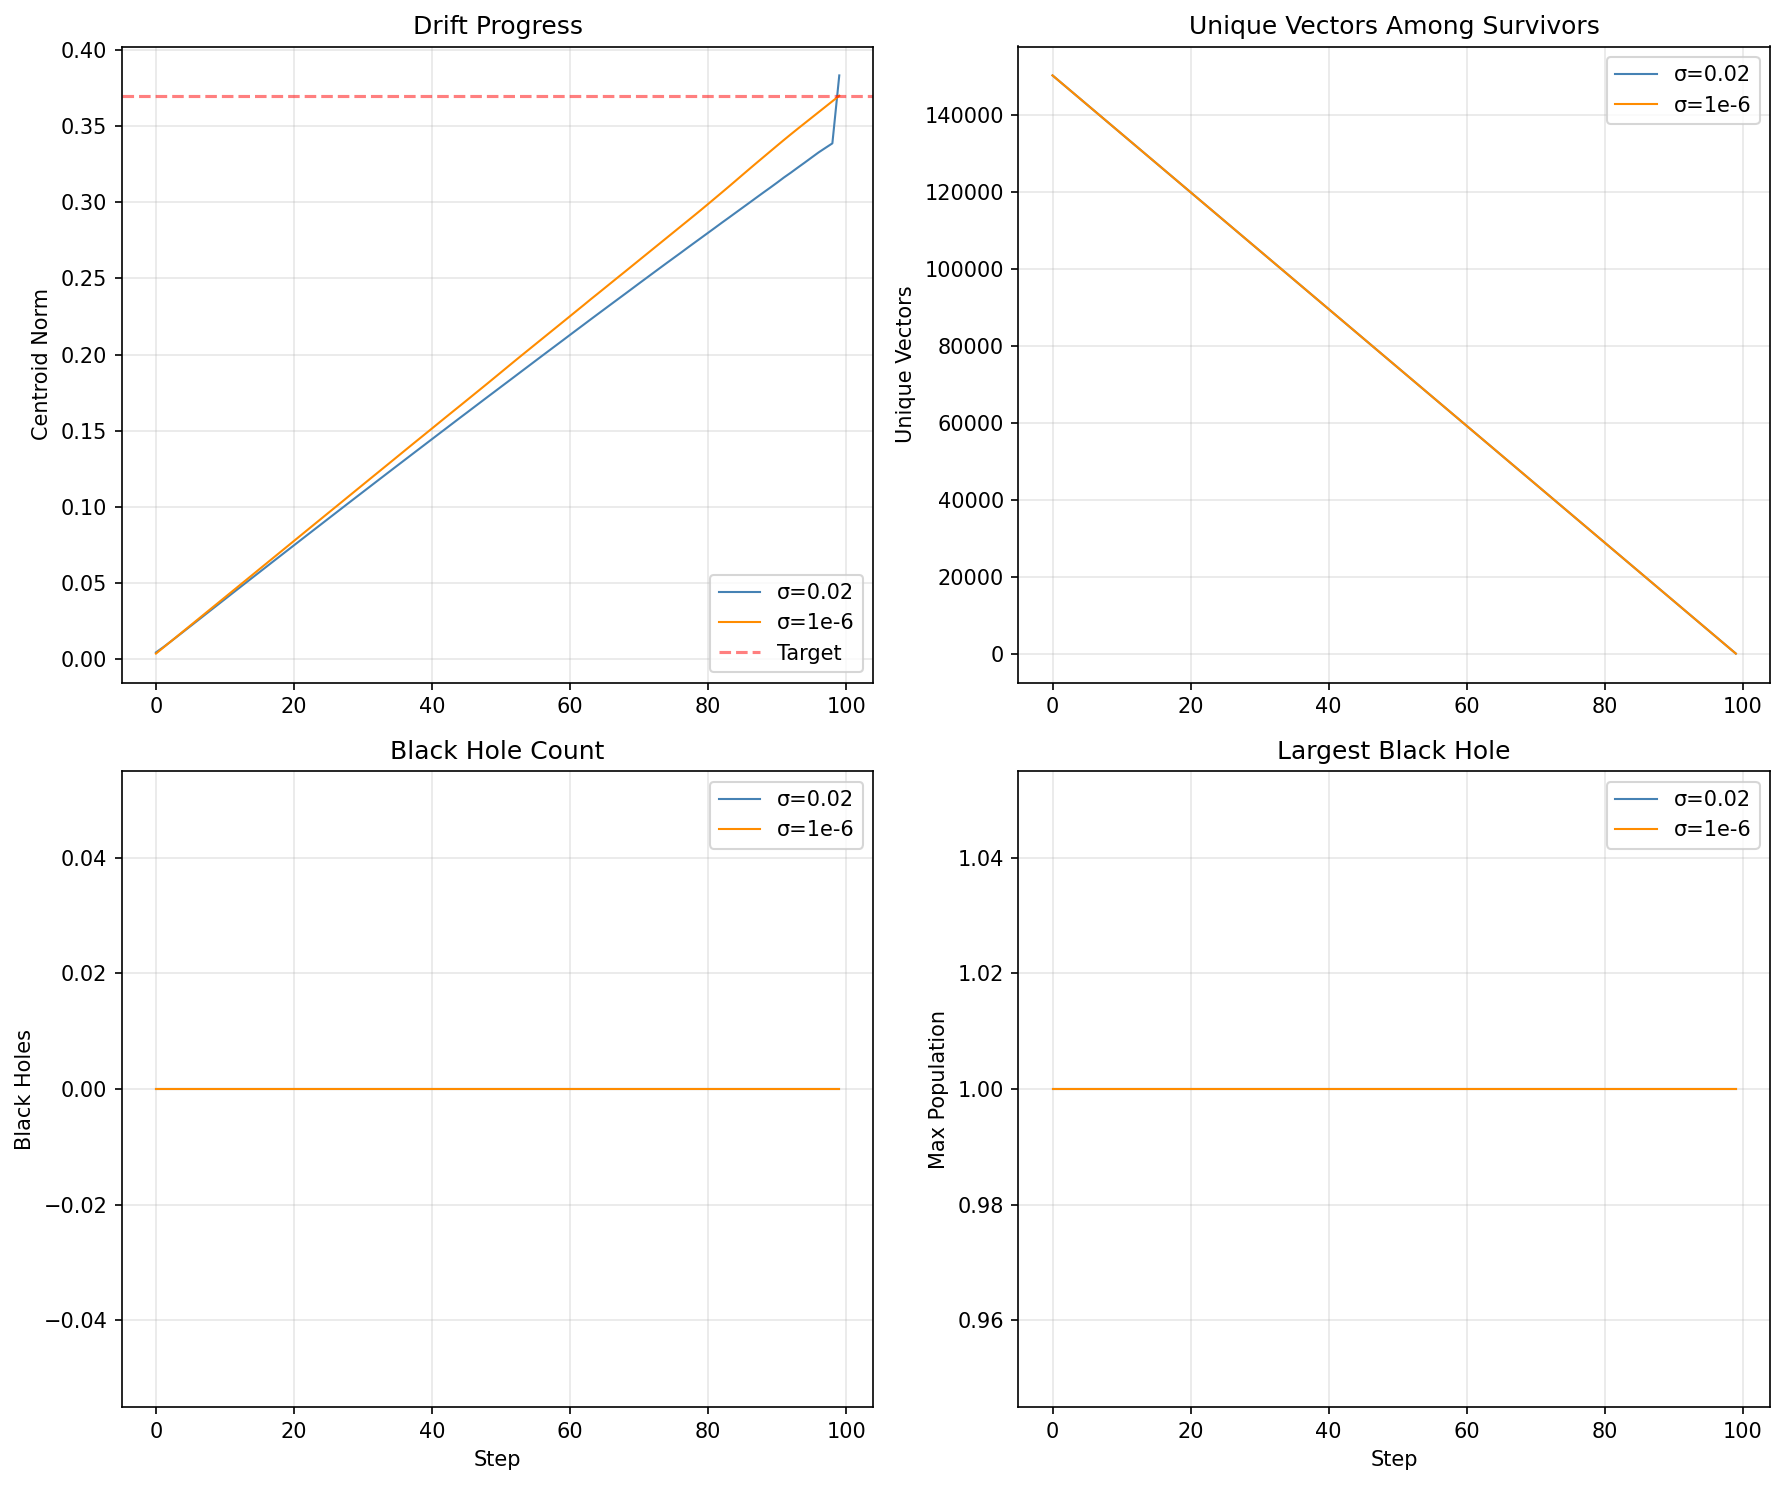

In [20]:
# Evolution plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)

for h, label, color in [(history_1, f'σ=0.02', 'steelblue'), 
                         (history_2, f'σ=1e-6', 'darkorange')]:
    axes[0,0].plot(h['step'], h['centroid_norm'], color=color, label=label, linewidth=1)
    axes[0,1].plot(h['step'], h['n_unique'], color=color, label=label, linewidth=1)
    axes[1,0].plot(h['step'], h['n_bh'], color=color, label=label, linewidth=1)
    axes[1,1].plot(h['step'], h['max_pop'], color=color, label=label, linewidth=1)

axes[0,0].axhline(TARGET_RADIUS, color='red', linestyle='--', alpha=0.5, label='Target')
axes[0,0].set_ylabel('Centroid Norm')
axes[0,0].set_title('Drift Progress')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].set_ylabel('Unique Vectors')
axes[0,1].set_title('Unique Vectors Among Survivors')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].set_xlabel('Step')
axes[1,0].set_ylabel('Black Holes')
axes[1,0].set_title('Black Hole Count')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].set_xlabel('Step')
axes[1,1].set_ylabel('Max Population')
axes[1,1].set_title('Largest Black Hole')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../../notebooks/analysis/drift_coalescence.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
print("=" * 60)
print("VERDICT")
print("=" * 60)
print()
print(f"σ = 0.02 (realistic): {r1['n_bh']} black holes formed")
print(f"σ = 1e-6 (tight):     {r2['n_bh']} black holes formed")
print()
if r1['n_bh'] > 0 or r2['n_bh'] > 0:
    print("Drift coalescence CAN produce black holes.")
else:
    print("Drift coalescence did NOT produce black holes.")
    print("Uniform translation preserves relative positions.")

VERDICT

σ = 0.02 (realistic): 0 black holes formed
σ = 1e-6 (tight):     0 black holes formed

Drift coalescence did NOT produce black holes.
Uniform translation preserves relative positions.
